<img src="https://miro.medium.com/max/2402/0*y_W6nAQZkx-F5ICQ"/>

# Mercari Price Suggestion Challenge
***
### Pricing suggestion to online sellers

The target of this challenge is to offer a pricing suggestion for people when they sell their products. Given the numerous number of products possible in different conditions, we cannot take the images of the product for the model (probably a very complex model can). We will be using the input data provided by the seller for this prediction.

By offering an optimal price for the user, it helps the user decide quickly on the price and also ensure a fair market price for the seller. This will probably help Mercari generate more revenue, ensure more transactions and also satisfy the consumers. 

### Dataset Features

- **ID**: the id of the listing
- **Name:** the title of the listing
- **Item Condition:** the condition of the items provided by the seller
- **Category Name:** category of the listing
- **Brand Name:** brand of the listing
- **Shipping:** 1 if shipping fee is paid by seller and 0 by buyer
- **Item Description:** the full description of the item
- **Price:** the price that the item was sold for. This is the target variable that you will predict. The unit is USD.

You can download the dataset [here](https://www.kaggle.com/c/mercari-price-suggestion-challenge)

<img src = "https://cdn.dribbble.com/users/56196/screenshots/2281553/mobile-dribbble.gif"/>

# Table of Content
***
### Define the Problem:

- [What's the Business Goal?](#A.-What's-the-business-goal?)

- [What metric are we optimizing?](#B.-What-metric-are-we-using?)

### Descriptive Statistics:
- [Observe Training Statistics](#Training-Statistics)

- [Missing Value Treatment](#Data-Cleaning)


### Exploratory Data Analysis:
- [Price Distribution & Log Transformation](#Price-Distribution)

- [Shipping Type Distribution](#Shipping-Distribution)

- [Category Distribution & Feature Engineering](#Top-10-Categories)

- [Brand Analysis](#Brand-Analysis)


### Text Processing:
- [Normalizing Words (Stemming, Lowercase, Punctuation, Stop Words](#Cleaning-up-text)

### Feature Extraction with Text:

- [CountVectorizer, TF-IDF, LabelBinarizer](#CountVectorizer)

- [Merge all the features together](#Merge-all-the-features-together)

### Model Building

- [Ridge Regression](#Ridge-Regression)

- [LightGBM](#LGBM-Model)

- [XGBoost](#XGBoost-Model)

- [Ensemble Model](#Ensemble-Model)

- [Making Pipelines](#Making-pipelines)

- [Ensemble Predictions](#Ensemble-Predictions)


# Define the Problem

### A. What's the business goal?

The objective is to come up with the right pricing algorithm that can we can use as a pricing recommendation to the users. Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business. 

### B. What metric are we using?

The normal metric we use for regression problem is MSE but the metric for this specific problem would be RMSLE. RMSLE is root mean square log error. By taking the log of the error, we are penalising more on errors on the lower predictions. This is like penalizing false negatives in a classification problem.


# Import Packages

In [2]:
# General packages
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing packages
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder

# Text cleaning
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Model Building and Evaluation packages
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


C:\Users\sabareesh\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Functions that we will use later on
def data_info(data):
    return data.info()

def creating_boxplots(size, target, features, data):
    plt.figure(figsize=size)
    for i in range(len(numerical_vars)):
        plt.subplot(5, 3, i+1)
        sns.boxplot(x=target, y=features[i], data=data )
        
def creating_distplot(size, data, features):
    plt.figure(figsize=size)
    for i in range(len(features)):
        plt.subplot(5, 3, i+1)
        sns.distplot(data[features[i]])
        
def crossCorrelation(data):
    corr = data.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, 
          xticklabels=corr.columns.values,
          yticklabels=corr.columns.values)
    print(corr)

## Training Statistics

The training set has about 600,000 observations

In [4]:
# Observe the training set
train = pd.read_csv('train.tsv', sep = '\t')

In [5]:
print("The size of the training data is: " + str(train.shape))
print(train.dtypes)

The size of the training data is: (1482535, 8)
train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


This much amount of data is unhealthy for my laptop. 😅
So, lets only work with 5% of data.

In [6]:
train = train.sample(frac=0.1)

In [7]:
train.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
612001,612001,MK WALLET,3,Women/Women's Accessories/Wallets,Michael Kors,34.0,0,MK AUTHENTIC vanilla logo wallet. Zip closure ...
522851,522851,Ralph Lauren tan w black flat shoes s 6,3,Women/Shoes/Flats,Lauren Ralph Lauren,16.0,0,Ralph Lauren tan with black flat shoes s 6! Gr...
236488,236488,14g Belly piercing kit,1,Women/Jewelry/Earrings,NaN,21.0,0,14g Belly piercing kit 5x Belly rings 5x 14g B...
710521,710521,Rebel Flag Lanyard Keychain,1,Handmade/Accessories/Lanyard,NaN,6.0,1,Great to use for hanging keys around your neck...
1309966,1309966,Tula Baby Ring Sling S/M,1,Kids/Gear/Backpacks & Carriers,NaN,86.0,0,Brand new in the box Tula ring sling. Size S/M
1260765,1260765,18pc Japanese keychain charm strap lot,3,Kids/Toys/Stuffed Animals & Plush,NaN,16.0,1,Thanks for viewing my item. Please read my bio...
1221265,1221265,LulaRoe classic tee XL,1,Women/Tops & Blouses/T-Shirts,LuLaRoe,14.0,0,Used once no fading or no pilling. The LLR tag...
1341884,1341884,Womens Philadelphia Eagles Windbreaker,2,Women/Athletic Apparel/Jackets,NFL,28.0,1,Womens Philadelphia Eagles Windbreaker Like Ne...
797881,797881,X large blouse,3,Women/Tops & Blouses/Blouse,Charlotte Russe,5.0,1,X large black blouse
918835,918835,Earring Lot 8 Pair Kokopelli Southwester,2,Women/Jewelry/Earrings,NaN,7.0,0,8 pairs of pierced earrings. Southwestern styl...


## Summary Statistics:
- Most item price are at 10 Dollars
- There are about 33k items with no descriptions
- There are 3751 unique brands
- Majority of the items are Women's Brand

In [8]:
train.astype('object').describe().transpose()

,count,unique,top,freq
train_id,74127,74127,917503,1
name,74127,70351,Bundle,113
item_condition_id,74127,5,1,31930
category_name,73782,926,"Women/Athletic Apparel/Pants, Tights, Leggings",2980
brand_name,42633,1818,PINK,2719
price,74127,376,10,5094
shipping,74127,2,0,40987
item_description,74127,67510,No description yet,4062


## Test Set
The testing set has about 700,000 observations

In [9]:
# Observe testing set
test = pd.read_csv('test.tsv', sep = '\t',engine = 'python')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [9]:
# We sample about 10% of t
test.shape

(693359, 7)

# Data Cleaning

In [13]:
 train.isnull().sum()

train_id                 0
name                     0
item_condition_id        0
category_name          614
brand_name           63135
price                    0
shipping                 0
item_description         0
dtype: int64

Not surprising to find that many entries don't have brand name since most products we use are not generally branded. Atleast not brands which add value by themselves like Nike or Gucci, etc.

In [8]:
# Create a function to impute missing values
def fill_missing_value(data):
    data['category_name'].fillna(value = 'Other/Other/Other', inplace=True)
    data['brand_name'].fillna(value = 'uknown', inplace=True)
    data['item_description'].fillna(value = 'No description yet', inplace=True)
    
    return data

In [10]:
fill_missing_value(train)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
612001,612001,MK WALLET,3,Women/Women's Accessories/Wallets,Michael Kors,34.0,0,MK AUTHENTIC vanilla logo wallet. Zip closure ...
522851,522851,Ralph Lauren tan w black flat shoes s 6,3,Women/Shoes/Flats,Lauren Ralph Lauren,16.0,0,Ralph Lauren tan with black flat shoes s 6! Gr...
236488,236488,14g Belly piercing kit,1,Women/Jewelry/Earrings,uknown,21.0,0,14g Belly piercing kit 5x Belly rings 5x 14g B...
710521,710521,Rebel Flag Lanyard Keychain,1,Handmade/Accessories/Lanyard,uknown,6.0,1,Great to use for hanging keys around your neck...
1309966,1309966,Tula Baby Ring Sling S/M,1,Kids/Gear/Backpacks & Carriers,uknown,86.0,0,Brand new in the box Tula ring sling. Size S/M
...,...,...,...,...,...,...,...,...
29652,29652,8 gamboy game bundle,3,Electronics/Video Games & Consoles/Games,Nintendo,16.0,1,8 games that still work to perfection
928593,928593,Plus size skort,3,"Women/Athletic Apparel/Skirts, Skorts & Dresses",uknown,7.0,0,Very cute Worn 2x Fits like 1/2x Brand: fashio...
1475637,1475637,100% Authentic Apple EarPods,1,Electronics/Cell Phones & Accessories/Headsets,uknown,12.0,1,Brand new factory sealed
1109896,1109896,Victoria's Secret Knockout Leggings,3,"Women/Athletic Apparel/Pants, Tights, Leggings",Victoria's Secret,20.0,1,ON HOLD Size medium Mid rise


# Exploratory Data Analysis

In [11]:
train.price.describe()

count    148254.000000
mean         26.840294
std          39.638960
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        1800.000000
Name: price, dtype: float64

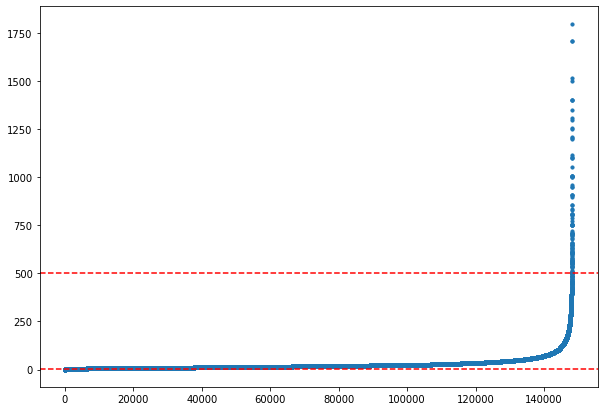

In [12]:
# Plotting sorted price against their index
sorted_price = sorted(train['price'])
y = sorted_price

plt.figure(figsize=(10,7))
plt.scatter(range(len(sorted_price)), y, s=10)

# We will see if there are any outliers assuming a minimium price of 3 dollars
plt.axhline(y=3, linestyle='--', color='r')
plt.axhline(y=500, linestyle='--', color='r')

There seems to be outliers in the price distribution with some values 0 and some as high as 2000. Let's look at them individually.

In [18]:
train[train.price>=1000]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
755632,755632,Saint Laurent envelope clutch crossbody,1,Women/Women's Handbags/Messenger & Crossbody,Saint Laurent,1260.0,1,Brand new Saint Laurent clutch/cross body in a...
1149578,1149578,Louis Vuitton Speedy 30,2,Women/Women's Handbags/Satchel,Louis Vuitton,1100.0,1,Louis Vuitton Speedy B 30. only used a few tim...
736116,736116,Louis Vuitton Delightful pm,3,Women/Women's Handbags/Shoulder Bag,uknown,1070.0,1,Authentic guaranteed. I have everything includ...
693165,693165,MacBook Pro,2,Electronics/Computers & Tablets/Laptops & Netb...,Apple,1350.0,1,"MacBook Pro with Retina 15"" Display 500 GB of ..."
1032857,1032857,Authentic Rose Ballerine Neverful MM,3,Women/Women's Handbags/Shoulder Bag,Louis Vuitton,1006.0,0,Authentic Rose Ballerine Neverful MM still in ...
999273,999273,Sprint iPhone7 128GB FREE SHIPPING,1,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,1209.0,0,iPhone 7 128GB color: BLACK Brand new in box w...
15769,15769,Celine Tri Colored Suede Mini luggage,3,Women/Women's Handbags/Totes & Shoppers,Celine,1009.0,0,Beautiful Celine mini luggage. In good conditi...
449729,449729,AUTH Louis Vuitton Palm Springs MM,2,Women/Women's Handbags/Backpack Style,Louis Vuitton,1808.0,0,This bag is in really good condition. Barely u...
724307,724307,Urban Decay bundle,1,Beauty/Makeup/Makeup Palettes,Urban Decay,1355.0,0,20 ultimate naked 20 tarte bloom 25 naked basic
288656,288656,INR PLUS STRIPS,1,Other/Other/Other,uknown,1000.0,1,This post is good for: 3 brand new machines 1 ...


The higher prices do not seem to be outliers but just expensive brands or products. The price of 0$ on the other hand might very well be the case of people just wanting to give stuff away for free. Having this data might have bad effects on the model. So, lets remove them

In [13]:
train = train[train.price != 0]

# Price Distribution

**Why take log(price)?** 

As discussed earlier, the metric we are going to use is the RMLSE, so we can take the log of the price as the target label. Doing this also ensures that the right-skewed distribution of the prices will take a normal curve shape.

In [14]:
train['log_price'] = np.log(train['price'])

C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
def create_histogram(size, data, features, **kwargs):
    plt.figure(figsize=size)
    if 'title' in kwargs:
        plt.suptitle(kwargs['title'])
    for i in range(len(features)):
        plt.subplot(1, 2, i+1)
        data[features[i]].plot.hist(bins=50, figsize=(15,6), edgecolor='white')
        plt.xlabel(features[i])
    

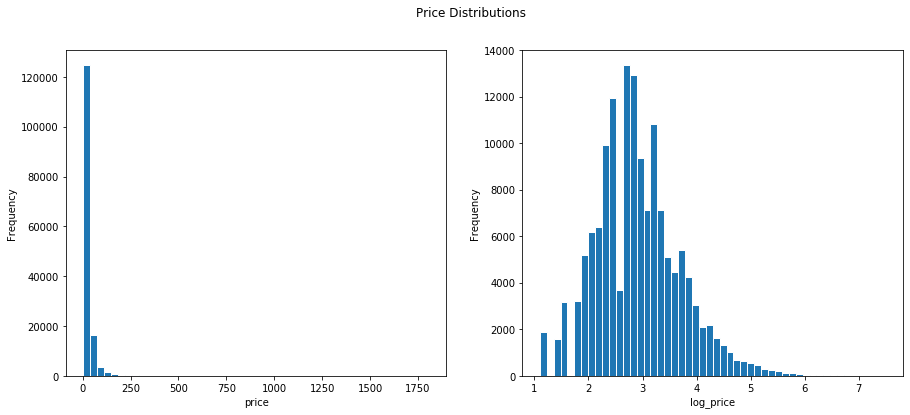

In [22]:
create_histogram((30, 12), train, ['price', 'log_price'], title='Price Distributions')

## Shipping Distribution

In [23]:
train['shipping'].value_counts() / len(train)

0    0.551928
1    0.448072
Name: shipping, dtype: float64

## Price Distribution by Shipping Type

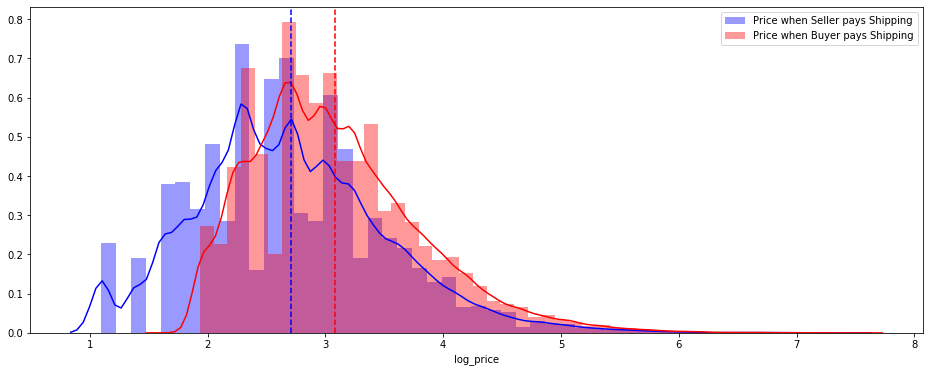

In [24]:
# Subsetting by clicks
no_shipping = train['shipping'] == 0
yes_shipping = train['shipping'] == 1
feature = 'log_price'

plt.figure(figsize=(16,6))
sns.distplot(train[feature][yes_shipping], label='Price when Seller pays Shipping', color="b")
sns.distplot(train[feature][no_shipping], label='Price when Buyer pays Shipping', color="r")
plt.axvline(train[feature][yes_shipping].mean(), linestyle = '--', color="b")
plt.axvline(train[feature][no_shipping].mean(), linestyle = '--', color="r")
plt.legend()


The prices when Buyer pays the shipping is higher. This is counter-intuitive since we expect the prices to be higher when seller is paying the shipping. This means that the average price of the products when the buyer pays for the shipping is higher. 

# Top 10 Categories 

In [25]:
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 6056
Women/Tops & Blouses/T-Shirts                                  4664
Beauty/Makeup/Face                                             3385
Beauty/Makeup/Lips                                             3055
Electronics/Video Games & Consoles/Games                       2646
Beauty/Makeup/Eyes                                             2483
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    2479
Women/Underwear/Bras                                           2063
Women/Tops & Blouses/Blouse                                    2029
Women/Jewelry/Necklaces                                        2017
Name: category_name, dtype: int64

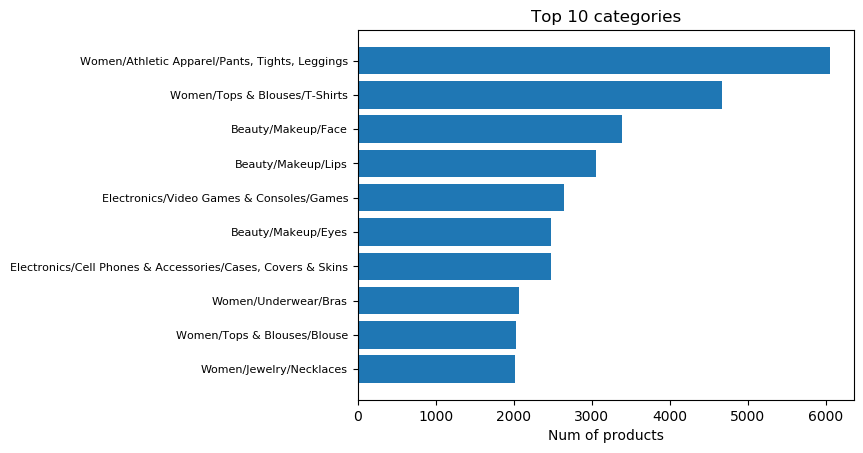

In [26]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = train['category_name'].value_counts()[:10].index
y_pos = np.arange(10)
performance = train['category_name'].value_counts()[:10].values
error = np.random.rand(len(people))

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people, fontsize=8)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Num of products')
ax.set_title('Top 10 categories')

plt.show()

The above graph clearly shows the user market for Merrcari is predominantly women and this is very helpful for Mercari to possibly take business decisions, modify the look of the websites and also advertise relevant products for the user base. 

## Split the categories into sub-categories

The category variable is mentioned in the format **Category/ Sub-Category/ Sub-Sub-Category**. Let's split this column into three columns to find the broader distributions like Women, Kids, Electronics, etc.

In [15]:
def transform_category_name(data, category_name):
    new = data[category_name].str.split("/", expand = True) 
    data['category_main'] = new[0]
    data['category_sub1'] = new[1]
    data['category_sub2'] = new[2]
    data.drop(columns =[category_name], inplace = True) 
    return data


In [16]:
train = transform_category_name(train, 'category_name')
# test = transform_category_name(test, 'category_name')

C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [29]:
train 

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,log_price,category_main,category_sub1,category_sub2
332088,332088,High-rise Jeggings - size 2,3,American Eagle,23.0,0,High-rise Jeggings in impeccable condition. Lo...,3.135494,Women,Jeans,"Slim, Skinny"
756162,756162,Infant enfamil Yellow,1,uknown,139.0,0,x13 cans 12.5oz Exp. 2018 Retail: [rm] each,4.934474,Kids,Other,Other
1461279,1461279,Starbucks brand new travel mug,1,Starbucks,21.0,0,Brand new Starbucks coffee mug . Bundle for le...,3.044522,Home,Kitchen & Dining,Coffee & Tea Accessories
236324,236324,LPS GREAT DANE,2,Littlest Pet Shop,20.0,0,lps dane! %100 authentic (you can see circle a...,2.995732,Kids,Toys,Dolls & Accessories
287698,287698,Men's 7 1/2 Reebok CrossFit nano pumps,3,Reebok,36.0,0,Used. In good condition.,3.583519,Men,Shoes,Athletic
...,...,...,...,...,...,...,...,...,...,...,...
925456,925456,Medium Carter's fleece pjs and 6 shirts,2,Carter's,26.0,0,"Carter's fleece pajama dresses from Carter's, ...",3.258097,Kids,Girls (4+),Dresses
790501,790501,Got 2 b styling kit,1,uknown,26.0,0,Comes with hair dryer glued blasting freeze sp...,3.258097,Beauty,Tools & Accessories,Hair Styling Tools
474646,474646,Bundle for cheeky tot*Keen shoes size 13,3,uknown,29.0,0,Great condition boys size 13 keen.,3.367296,Kids,Girls 2T-5T,Shoes
362207,362207,Xbox wireless controller blue,3,Xbox,34.0,0,"Xbox wireless controller, good condition!",3.526361,Electronics,Video Games & Consoles,Accessories


# Top 10 Main Category

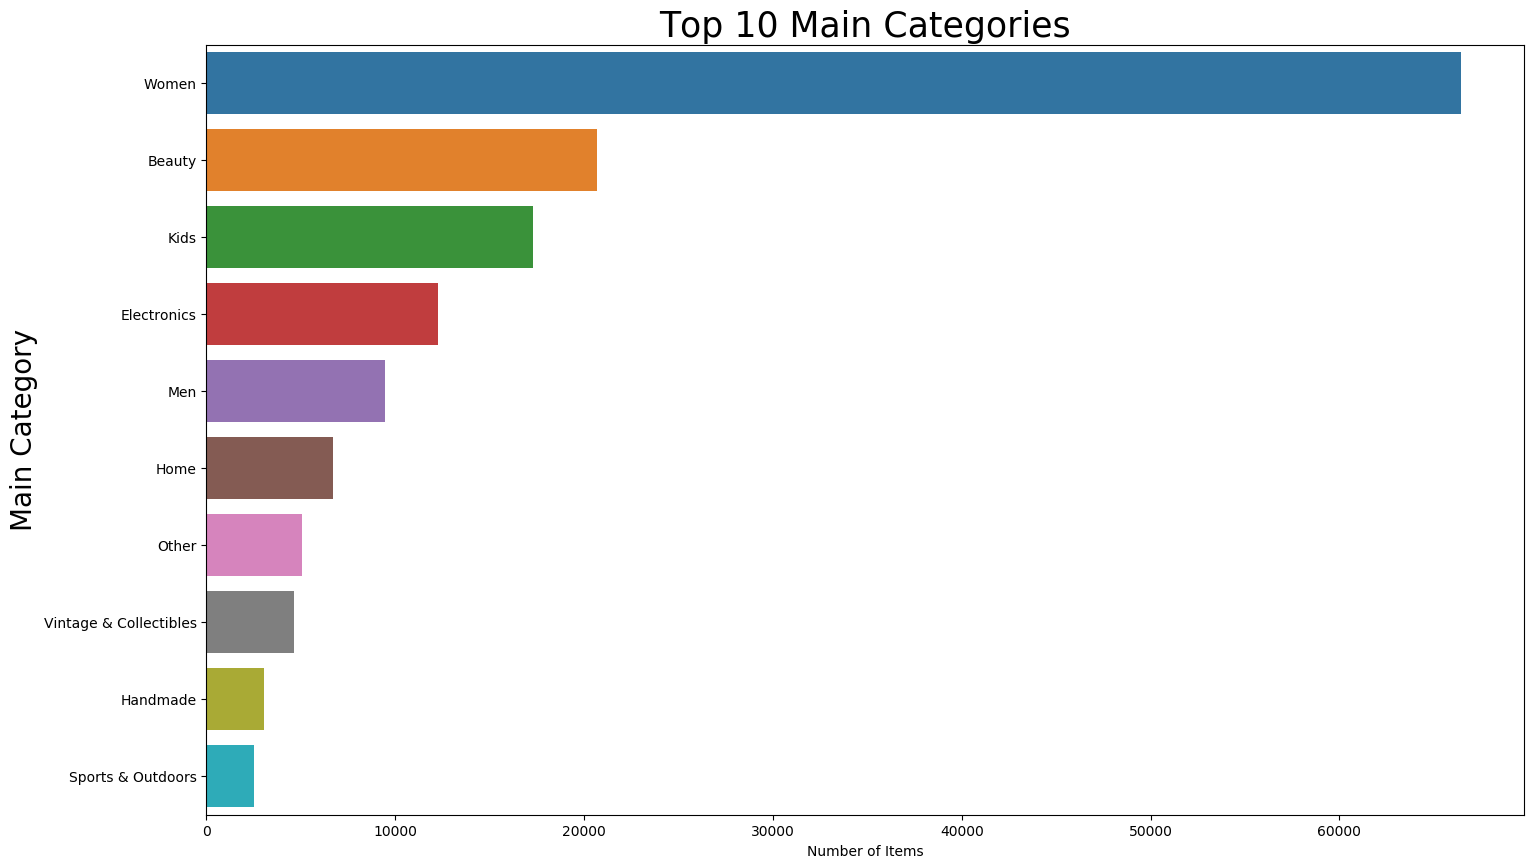

In [30]:
plt.figure(figsize=(17,10))
sns.countplot(y = train['category_main'], order = train['category_main'].value_counts().index, orient = 'v')
plt.title('Top 10 Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

# Ratio of Main Category 
Women takes up about 45 percent of the main category

In [31]:
# Look at the ratio of category for items
train['category_main'].value_counts()/len(train)

Women                     0.448362
Beauty                    0.139595
Kids                      0.116813
Electronics               0.082747
Men                       0.063744
Home                      0.045443
Other                     0.034194
Vintage & Collectibles    0.031258
Handmade                  0.020629
Sports & Outdoors         0.017215
Name: category_main, dtype: float64

# Brand Analysis

There is about 3750 unique brands 

In [32]:
# Amount of unique brand names
train['brand_name'].nunique()

2295

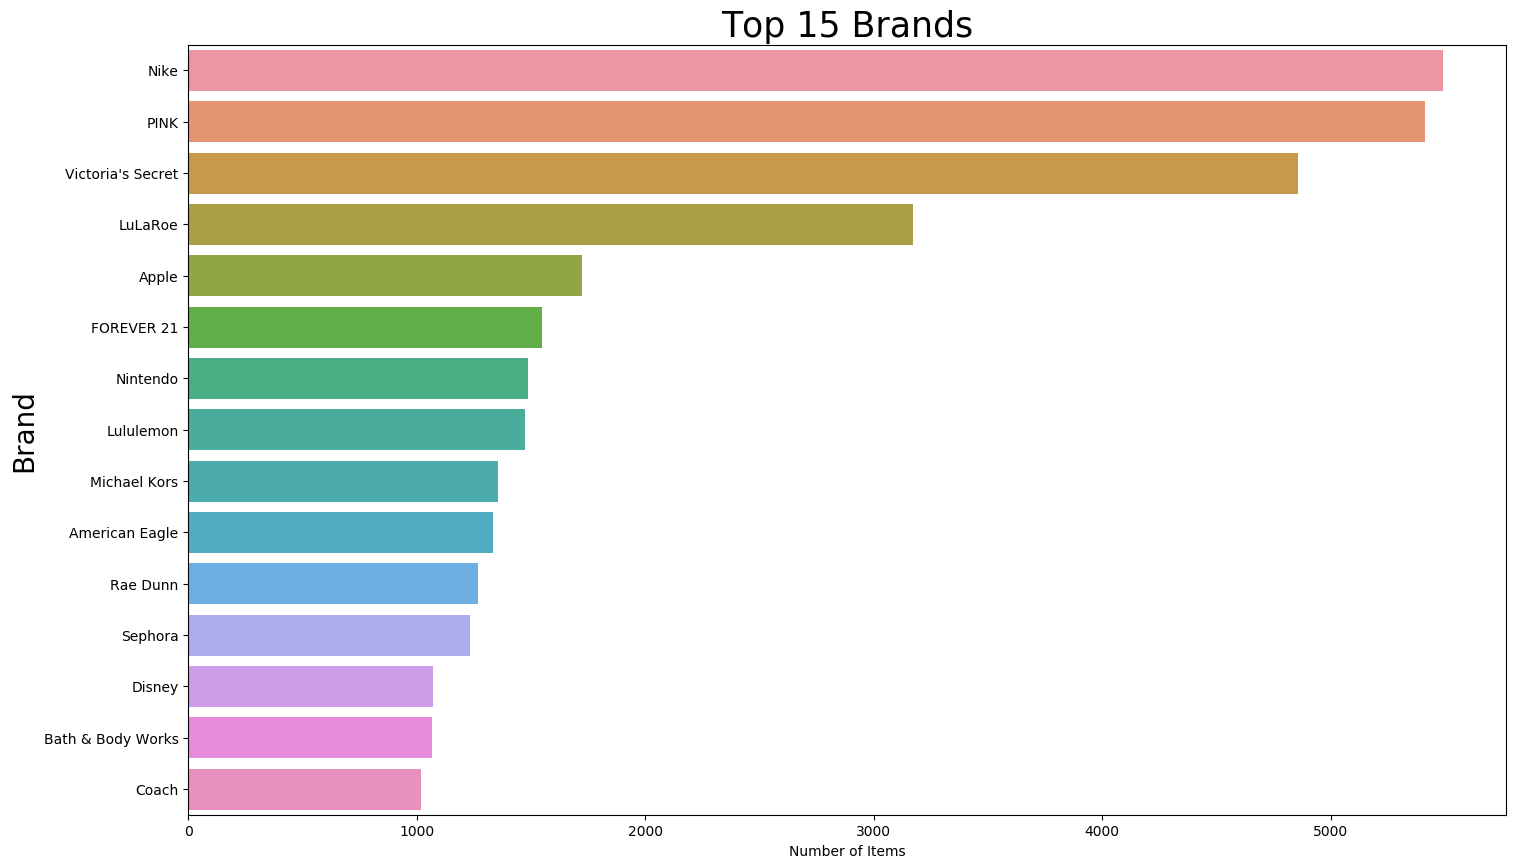

In [33]:
plt.figure(figsize=(17,10))
sns.countplot(y = train['brand_name'], order = train['brand_name'].value_counts().index[1:16], orient = 'v')
plt.title('Top 15 Brands', fontsize = 25)
plt.ylabel('Brand', fontsize = 20)
plt.xlabel('Number of Items')
plt.show()

## Top 20 Expensive Brands

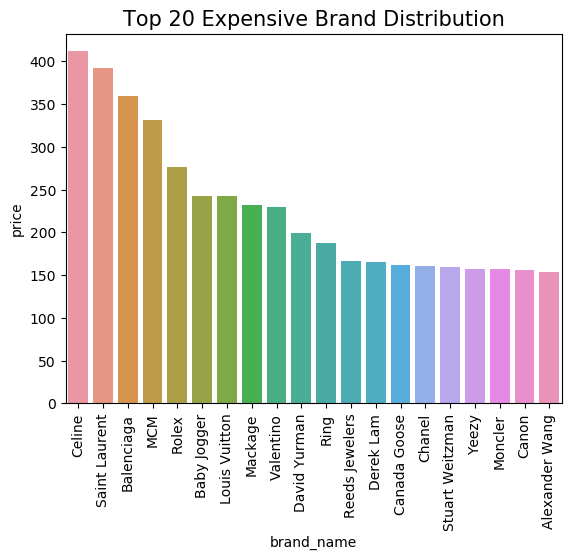

In [34]:
top_20_exp_brand = pd.DataFrame(train.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_20_exp_brand)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 20 Expensive Brand Distribution', fontsize=15)
plt.show()

# Text Processing
***
As with any text especially the one typed by users, it is necessary to clean the text. Because they tend to write the text in a casual way without spellcheck, etc.

Let's normalize the words by:
- Removing Punctuations
- Removing Stop Words
- Lowercasing the Words
- Stemming the Words

### List of Stop Words

In [35]:
# Examine list of stop words
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Create Function to clean up the text

In [18]:
def clean_text(text):
    '''
    Performs cleaning of the text.
    '''
    # Removes next line characters if any
    text = re.sub("\n","",text)

    # Removes any special characters
    text = re.sub(r'\W+', ' ', text)
    
    # Tokenize the text
    text = word_tokenize(text)
    
    stop =stopwords.words('english')
    
    # Removes stopwords and converts into lower-case
    text = ' '.join([item.lower() for item in text if item not in stop])
    return text

### Cleaning up text

In [19]:
# Stem the Words
porter = PorterStemmer()

train['item_description'] = train['item_description'].apply(clean_text)
train['item_description'] = train['item_description'].apply(porter.stem)


train['name'] = train['name'].apply(clean_text)
train['name'] = train['name'].apply(porter.stem)

C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sabareesh\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

# Feature Extraction with Text
***
## Word Frequency Weights

Since most ML models don't recognise text, we convert them into numbers and each word is assumed to be one vector. The three most common methods of assigning these feature values are:
- **Frequency Weight (Count Vectorizer):**
Returns a vector with counting the number of times each words has appeared in the text instance/document.  
- **TF-IDF Weight:**
Calculates a number proportional to the number of times a word appears in the text instance/document and inversely proportional to the number of times it appears in the document.
- **Binary (Label Binarizer):**
Returns a vector telling just whether the word appeared or not.


# Feature Engineering
***
# CountVectorizer

In [37]:
# CountVectorizer - name 
# While the categories seem to be unique, the name is user input and hence has a lot of variation. Ex: Shirt and Red Shirt
# are not completely independent. So, we will use CountVectorizer for name.

cv = CountVectorizer(min_df=10, ngram_range=(1,2))
X_name = cv.fit_transform(train['name'])

# LabelBinarizer

In [38]:
# Apply LabelBinarizer to brand names and category names as they tend to be unique.

lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(train['brand_name'])
X_main = lb.fit_transform(train['category_main'])
X_sub1 = lb.fit_transform(train['category_sub1'])
X_sub2 = lb.fit_transform(train['category_sub2'])

In [39]:
print("Item Brand Shape: " + str(X_brand.shape))

Item Brand Shape: (74076, 1815)


# Get_Dummies

In [40]:
# item_condition_id is a ordinal variable and cannot be considered numeric. So, apply get_dummies to 
# "item_condition_id" and then convert into a CSR Matrix
X_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id']], sparse=True, drop_first=True).values)

All the categories till now like Brand, name and categories are always less than a sentence long and there is no scope for repetition. The decsription on the other hand might be long and will have repetitive words throughout. So, it's better to use **TF-IDF** for this column.


# TFIDF

**TF Term Frequency** proportional to the number of times a term appears on the instance. 

**IDF Inverse Document Frequency** inversely proportional to the number of times a text appears throughout the corpus.

We essentially multiply both the above terms to assign a value to a word.

In [41]:
# Perform a TFIDF Transformation of the item description with the top 55000 features and has an n-gram range of 1-2
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2))
X_desc = tv.fit_transform(train['item_description'])

In [42]:
print("Item Description Shape: " + str(X_desc.shape))

Item Description Shape: (74076, 55000)


### TFIDF Weights value check

In [43]:
tfidf = dict(zip(tv.get_feature_names(), tv.idf_))

sorted(tfidf.items(), key=lambda s: s[1], reverse=True)[:20]

[('07 lc', 11.519713191179841),
 ('13oz bottle', 11.519713191179841),
 ('2016 leaf', 11.519713191179841),
 ('6x9 standard', 11.519713191179841),
 ('_____', 11.519713191179841),
 ('_______', 11.519713191179841),
 ('________', 11.519713191179841),
 ('active spacedye', 11.519713191179841),
 ('babe ruth', 11.519713191179841),
 ('bath seat', 11.519713191179841),
 ('bedhead', 11.519713191179841),
 ('bottle garnier', 11.519713191179841),
 ('bristles full', 11.519713191179841),
 ('brush app', 11.519713191179841),
 ('brush bristles', 11.519713191179841),
 ('cards added', 11.519713191179841),
 ('career achievements', 11.519713191179841),
 ('caty', 11.519713191179841),
 ('clear proof', 11.519713191179841),
 ('concert promotion', 11.519713191179841)]

Frankly speaking, this list doesn't make much sense because we are weighing based on the rarity of the word alone and not necessarily on it's dependence with weight.

In [44]:
sorted(tfidf.items(), key=lambda s: s[1])[:20]

[('new', 2.1700457539825586),
 ('size', 2.337926626621719),
 ('brand', 2.7303577389698592),
 ('brand new', 2.846285777732967),
 ('free', 2.9084833578372202),
 ('no', 2.9807585079820904),
 ('condition', 3.0587729413144014),
 ('worn', 3.095732381485782),
 ('never', 3.2788006494909414),
 ('used', 3.281308405045264),
 ('great', 3.3479724379655966),
 ('black', 3.3949701707942728),
 ('shipping', 3.408985608205351),
 ('rm', 3.4091357696291635),
 ('price', 3.464714202117857),
 ('ship', 3.5181906751927934),
 ('color', 3.601266504902064),
 ('bundle', 3.634760245420027),
 ('like', 3.6453543664499595),
 ('good', 3.68591488888087)]

While the words like 'new', 'brand' are repetitive, these might hold more value to the price. So, tf-idf is not necessarily the most useful feature extraction tool for this problem. We will see later if this affects the solution.

# Merge all the features together

In [20]:
# Making a pipeline
def feature_extraction_1(data):
    cv = CountVectorizer(min_df=10, ngram_range=(1,2))
    X_name = cv.fit_transform(data['name'])
    
    ohe = OneHotEncoder(drop='first')
    X_misc = ohe.fit_transform(data[['brand_name', 'category_main', 'category_sub1', 'category_sub2']])
    
    X_dummies = csr_matrix(pd.get_dummies(data[['shipping', 'item_condition_id']], sparse=True, drop_first=True).values)
    
    tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2))
    X_desc = tv.fit_transform(data['item_description'])
    
    return hstack((X_name, X_dummies, X_misc, X_desc)).tocsr()

def feature_extraction_2(data):

    cv = CountVectorizer(min_df=10, ngram_range=(1,2))
    cols = ['brand_name', 'category_main', 'category_sub1', 'category_sub2', 'name', 'item_description']
    X_comb = cv.fit_transform(data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1))
    
    X_dummies = csr_matrix(pd.get_dummies(data[['shipping', 'item_condition_id']], sparse=True, drop_first=True).values)
        
    return hstack((X_comb, X_dummies)).tocsr().astype(np.float64)



In [22]:
def rmsle(y, pred): return np.sqrt(mean_squared_error(y, pred))

train_features_2 = feature_extraction_2(train)
train_features_1 = feature_extraction_1(train)

## Ridge Regression

In [23]:
%%time
# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(train_features_2):
    # Define LGBM Model
    model_ridge = Ridge(solver = "sag", fit_intercept=True, random_state=42)
    
    # Fit LGBM Model
    model_ridge.fit(train_features_2[train_ids], train.iloc[train_ids]['log_price'])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_ridge.predict(train_features_2[train_ids])
    rmsle_train = rmsle(y_pred_train, train.iloc[train_ids]['log_price'])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_ridge.predict(train_features_2[valid_ids])
    rmsle_valid = rmsle(y_pred_valid, train.iloc[valid_ids]['log_price'])
    
    print('Ridge Training RMSLE: {:.5f}'.format(rmsle_train))
    print('Ridge Validation RMSLE: {:.5f}'.format(rmsle_valid))

Ridge Training RMSLE: 0.40397
Ridge Validation RMSLE: 0.57226
Ridge Training RMSLE: 0.40196
Ridge Validation RMSLE: 0.57333
Ridge Training RMSLE: 0.39932
Ridge Validation RMSLE: 0.57833
Wall time: 2min 10s


## LGBM Model

In [207]:
# Create 3-Fold CV
cv = KFold(n_splits=3, shuffle=True, random_state=42)
for train_ids, valid_ids in cv.split(train_features_2):
    # Define LGBM Model
    model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
    # Fit LGBM Model
    model_lgb.fit(train_features_2[train_ids], train.iloc[train_ids]['log_price'])
    
    # Predict & Evaluate Training Score
    y_pred_train = model_lgb.predict(train_features_2[train_ids])
    rmsle_train = rmsle(y_pred_train, train.iloc[train_ids]['log_price'])
    
    # Predict & Evaluate Validation Score
    y_pred_valid = model_lgb.predict(train_features_2[valid_ids])
    rmsle_valid = rmsle(y_pred_valid, train.iloc[valid_ids]['log_price'])

    print('LGBM Training RMSLE: {:.5f}'.format(rmsle_train))
    print('LGBM Validation RMSLE: {:.5f}'.format(rmsle_valid))

LGBM Training RMSLE: 0.46442
LGBM Validation RMSLE: 0.54350
LGBM Training RMSLE: 0.46754
LGBM Validation RMSLE: 0.54315
LGBM Training RMSLE: 0.46733
LGBM Validation RMSLE: 0.54297


In [24]:
train_features_1 = feature_extraction_1(train)

In [25]:
n_comp = 100
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(train_features_1)

TruncatedSVD(algorithm='arpack', n_components=100, n_iter=5, random_state=None,
             tol=0.0)

In [26]:
train_truncated = svd_obj.transform(train_features_1)

In [27]:
train_ids, valid_ids = train_test_split(np.arange(len(train)), test_size=0.25)

## XGBoost model

In [29]:
model_xgb = XGBRegressor()

# Fit XGBoost Model
model_xgb.fit(train_truncated[train_ids], train.iloc[train_ids]['log_price'])

# Predict & Evaluate Training Score
y_pred_train = model_xgb.predict(train_truncated[train_ids])
rmsle_train = rmsle(y_pred_train, train.iloc[train_ids]['log_price'])

# Predict & Evaluate Validation Score
y_pred_valid = model_xgb.predict(train_truncated[valid_ids])
rmsle_valid = rmsle(y_pred_valid, train.iloc[valid_ids]['log_price'])

print('XGBoost Training RMSLE: {:.5f}'.format(rmsle_train))
print('XGBoost Validation RMSLE: {:.5f}'.format(rmsle_valid))

[10:50:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Training RMSLE: 0.65043
XGBoost Validation RMSLE: 0.65643


# Ensemble Model

## LGBM + Ridge + XGBoost

## Making pipelines

In [41]:
class DataFrameSlicer(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
ds1_pipe_1 = make_pipeline(
       DataFrameSlicer('name'), 
       CountVectorizer(min_df=10, ngram_range=(1,2))
)

ds1_pipe_2 = make_pipeline(
       DataFrameSlicer(['brand_name', 'category_main', 'category_sub1', 'category_sub2', 'shipping', 'item_condition_id']), 
       OneHotEncoder(handle_unknown='ignore')
)

ds1_pipe_3 = make_pipeline(
       DataFrameSlicer('item_description'), 
       TfidfVectorizer(max_features=55000, ngram_range=(1, 2))
)

feature_union_1 = make_union(ds1_pipe_1, ds1_pipe_2, ds1_pipe_3)

In [42]:
class Combiner(TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
    
ds2_pipe_1 = make_pipeline(
       DataFrameSlicer(['brand_name', 'category_main', 'category_sub1', 'category_sub2', 'name', 'item_description']), 
       Combiner(),
       CountVectorizer(min_df=10, ngram_range=(1,2))
)

ds2_pipe_2 = make_pipeline(
       DataFrameSlicer(['shipping', 'item_condition_id']), 
       OneHotEncoder(categories='auto', handle_unknown='ignore')
)

feature_union_2 = make_union(ds2_pipe_1, ds2_pipe_2)

In [43]:
train, test = train_test_split(train, test_size=0.25)

train_features_1 = feature_union_1.fit_transform(train)
test_features_1 = feature_union_1.transform(test)

In [44]:
train_features_2 = feature_union_1.fit_transform(train)
test_features_2 = feature_union_1.transform(test)

In [46]:
model_ridge = Ridge(solver = "sag", fit_intercept=True, random_state=42)

# Fit Ridge Model
model_ridge.fit(train_features_2, train['log_price'])

# Predict & Evaluate Training Score
y_pred_train_ridge = model_ridge.predict(train_features_2)
rmsle_train = rmsle(y_pred_train_ridge, train['log_price'])

# Predict & Evaluate Validation Score
y_pred_test_ridge = model_ridge.predict(test_features_2)
rmsle_test = rmsle(y_pred_test_ridge, test['log_price'])

print('Ridge Training RMSLE: {:.5f}'.format(rmsle_train))
print('Ridge Testing RMSLE: {:.5f}'.format(rmsle_test))

Ridge Training RMSLE: 0.40478
Ridge Testing RMSLE: 0.53402


In [47]:
model_lgb = lgb.LGBMRegressor(num_leaves=31, n_jobs=-1, learning_rate=0.1, n_estimators=500, random_state=42)
    
# Fit LGBM Model
model_lgb.fit(train_features_2, train['log_price'])

# Predict & Evaluate Training Score
y_pred_train_lgbm = model_lgb.predict(train_features_2)
rmsle_train = rmsle(y_pred_train_lgbm, train['log_price'])

# Predict & Evaluate Validation Score
y_pred_test_lgbm = model_lgb.predict(test_features_2)
rmsle_test = rmsle(y_pred_test_lgbm, test['log_price'])

print('LGBM Training RMSLE: {:.5f}'.format(rmsle_train))
print('LGBM Testing RMSLE: {:.5f}'.format(rmsle_test))

LGBM Training RMSLE: 0.48880
LGBM Testing RMSLE: 0.52887


In [48]:
n_comp = 100
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(train_features_1)

train_truncated = svd_obj.transform(train_features_1)
test_truncated = svd_obj.transform(test_features_1)

In [50]:
model_xgb = XGBRegressor()

# Fit XGBoost Model
model_xgb.fit(train_truncated, train['log_price'])

# Predict & Evaluate Training Score
y_pred_train_xgb = model_xgb.predict(train_truncated)
rmsle_train = rmsle(y_pred_train_xgb, train['log_price'])

# Predict & Evaluate Validation Score
y_pred_test_xgb = model_xgb.predict(test_truncated)
rmsle_test = rmsle(y_pred_test_xgb, test['log_price'])

print('XGBoost Training RMSLE: {:.5f}'.format(rmsle_train))
print('XGBoost Testing RMSLE: {:.5f}'.format(rmsle_test))

XGBoost Training RMSLE: 0.64743
XGBoost Testing RMSLE: 0.65065


## Ensemble Predictions

In [53]:
ensemble_y_pred_train = (y_pred_train_xgb+y_pred_train_lgbm+y_pred_train_ridge)/3
ensemble_y_pred_test = (y_pred_test_xgb+y_pred_test_lgbm+y_pred_test_ridge)/3

rmsle_train = rmsle(ensemble_y_pred_train, train['log_price'])
rmsle_test = rmsle(ensemble_y_pred_test, test['log_price'])

print('Ensemble Training RMSLE: {:.5f}'.format(rmsle_train))
print('Ensemble Testing RMSLE: {:.5f}'.format(rmsle_test))

Ensemble Training RMSLE: 0.47862
Ensemble Testing RMSLE: 0.53156
